<a href="https://colab.research.google.com/github/reeaarana/Person-Re-identification-through-Siamese-Networks/blob/main/DL_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=42068ab438e4d55b0383a6a7ec1e5744a462f29d053a3ce27bab128990d6db34
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=78fcf431f6b34dd0644a68a4e9aa57ce1480cc544076aa2a86066c0af55f20b3
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

In [3]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 16.10 MiB/s, done.


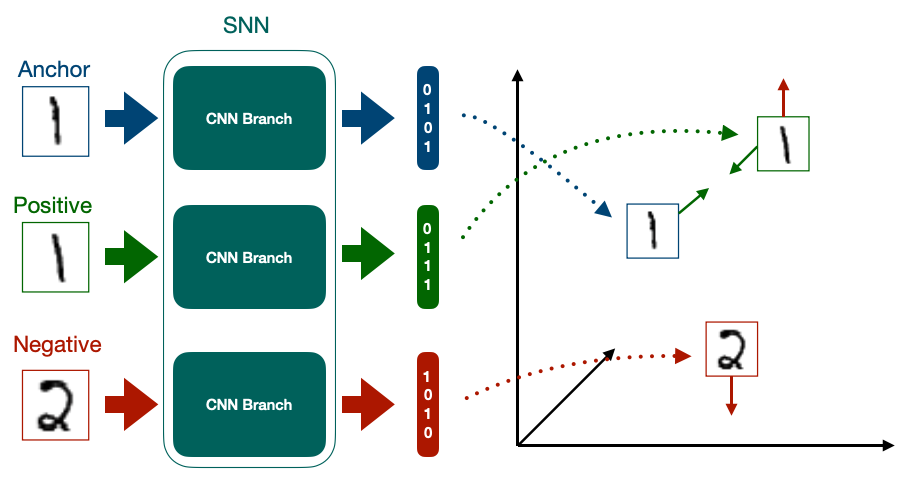

# Imports

In [4]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [6]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [8]:
row = df.iloc[38]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

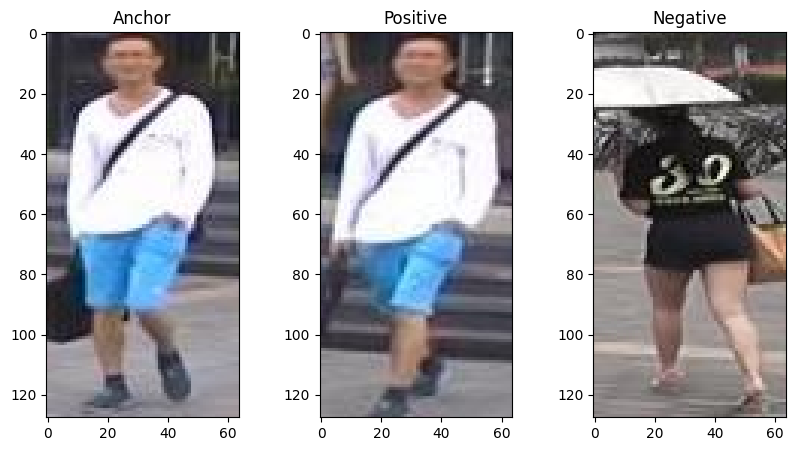

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [10]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

#APN Dataset

In [11]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img





In [12]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


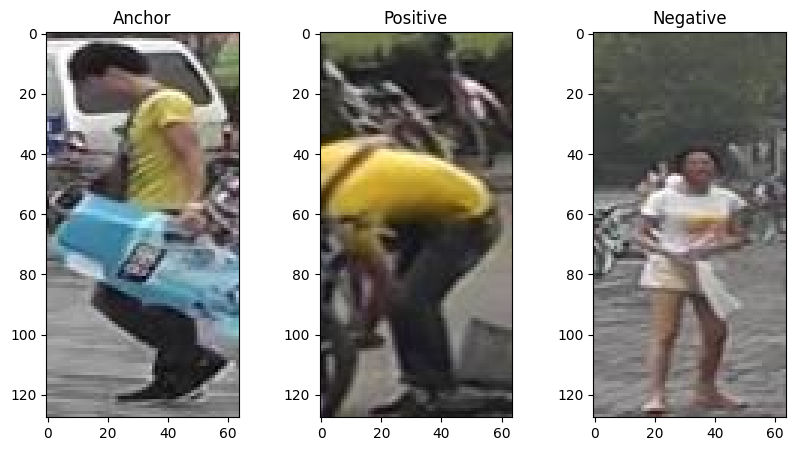

In [13]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [14]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Model

In [17]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings



In [41]:
model = APN_Model()
model.to(DEVICE);


In [18]:
model = APN_Model()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

#Train and Eval function

In [19]:
def train_fn(model, DataLoader, optimizer, criterion):

  model.train() # NO Dropout
  total_loss = 0.0

  for A, P, N in tqdm(DataLoader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(DataLoader)

In [20]:
def eval_fn(model, DataLoader, criterion):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(DataLoader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(DataLoader)

In [21]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Training Loop

In [22]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.5858275885879993 valid_loss : 0.7225545513629913


100%|██████████| 25/25 [00:02<00:00, 10.30it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.2589414170384407 valid_loss : 0.2720510452985764


100%|██████████| 25/25 [00:02<00:00, 10.83it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.17078587904572487 valid_loss : 0.2701228779554367


100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.1302042643725872 valid_loss : 0.21332729876041412


100%|██████████| 25/25 [00:02<00:00, 10.63it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 5 train_loss : 0.08372178390622138 valid_loss : 0.15560377568006514


100%|██████████| 25/25 [00:02<00:00, 10.82it/s]


EPOCHS : 6 train_loss : 0.08182180017232894 valid_loss : 0.19842949211597444


100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


EPOCHS : 7 train_loss : 0.07399854384362697 valid_loss : 0.16008999884128572


100%|██████████| 25/25 [00:02<00:00, 10.60it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 train_loss : 0.038945059329271316 valid_loss : 0.12685686528682708


100%|██████████| 25/25 [00:02<00:00, 10.76it/s]


EPOCHS : 9 train_loss : 0.035511165857315063 valid_loss : 0.13365097522735594


100%|██████████| 25/25 [00:02<00:00, 10.20it/s]


EPOCHS : 10 train_loss : 0.04715576440095901 valid_loss : 0.13643930852413177


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


EPOCHS : 11 train_loss : 0.05037219077348709 valid_loss : 0.1536271494626999


100%|██████████| 25/25 [00:02<00:00,  8.43it/s]


EPOCHS : 12 train_loss : 0.045995870679616926 valid_loss : 0.16087815344333647


100%|██████████| 25/25 [00:02<00:00, 10.61it/s]


EPOCHS : 13 train_loss : 0.055981014519929886 valid_loss : 0.14953167617321014


100%|██████████| 25/25 [00:02<00:00, 10.78it/s]


EPOCHS : 14 train_loss : 0.03577152565121651 valid_loss : 0.15735929787158967


100%|██████████| 25/25 [00:02<00:00,  8.98it/s]

EPOCHS : 15 train_loss : 0.017413916885852813 valid_loss : 0.1442531418800354


#Anchor Embeddings

In [25]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [26]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:45<00:00, 87.94it/s]


In [28]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.246738,-1.830139,1.429517,-1.358428,0.482185,-0.204822,-0.686857,0.317486,1.376105,...,-0.277693,-0.340465,0.586634,0.699640,-0.828586,1.422412,0.990190,-0.297564,-0.161848,-0.668360
1,1420_c3s3_061978_03.jpg,0.749224,-1.939451,1.031290,-1.391298,0.408867,-0.786926,-0.653084,0.356342,0.670268,...,-0.089305,-0.597738,-0.588615,0.307097,-1.147336,1.303925,0.067524,-0.769897,0.369850,-1.164141
2,1420_c5s3_062565_05.jpg,0.159894,-1.676521,0.807144,-1.137762,0.297441,-0.230042,-0.551949,0.153743,0.662269,...,-0.234386,-0.419999,-0.091633,0.496912,-0.704997,0.936905,0.442917,-0.530540,0.145303,-0.495640
3,1420_c6s3_085592_04.jpg,0.046693,-0.952221,0.375417,-0.970691,0.207872,0.308832,-0.309109,0.007040,0.756201,...,-0.226029,-0.307047,0.393544,0.415683,-0.402965,0.846781,0.420572,-0.520531,0.189216,-0.375053
4,0663_c5s3_085987_03.jpg,-0.385092,0.897257,-0.920611,0.913237,-0.254951,1.318184,0.369940,-0.909281,0.170974,...,-0.176819,0.148087,1.028741,-0.298855,1.158053,-0.184856,-0.018425,-0.380069,-0.468383,0.900091


# Inference

In [29]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [32]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [33]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [34]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)


In [39]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


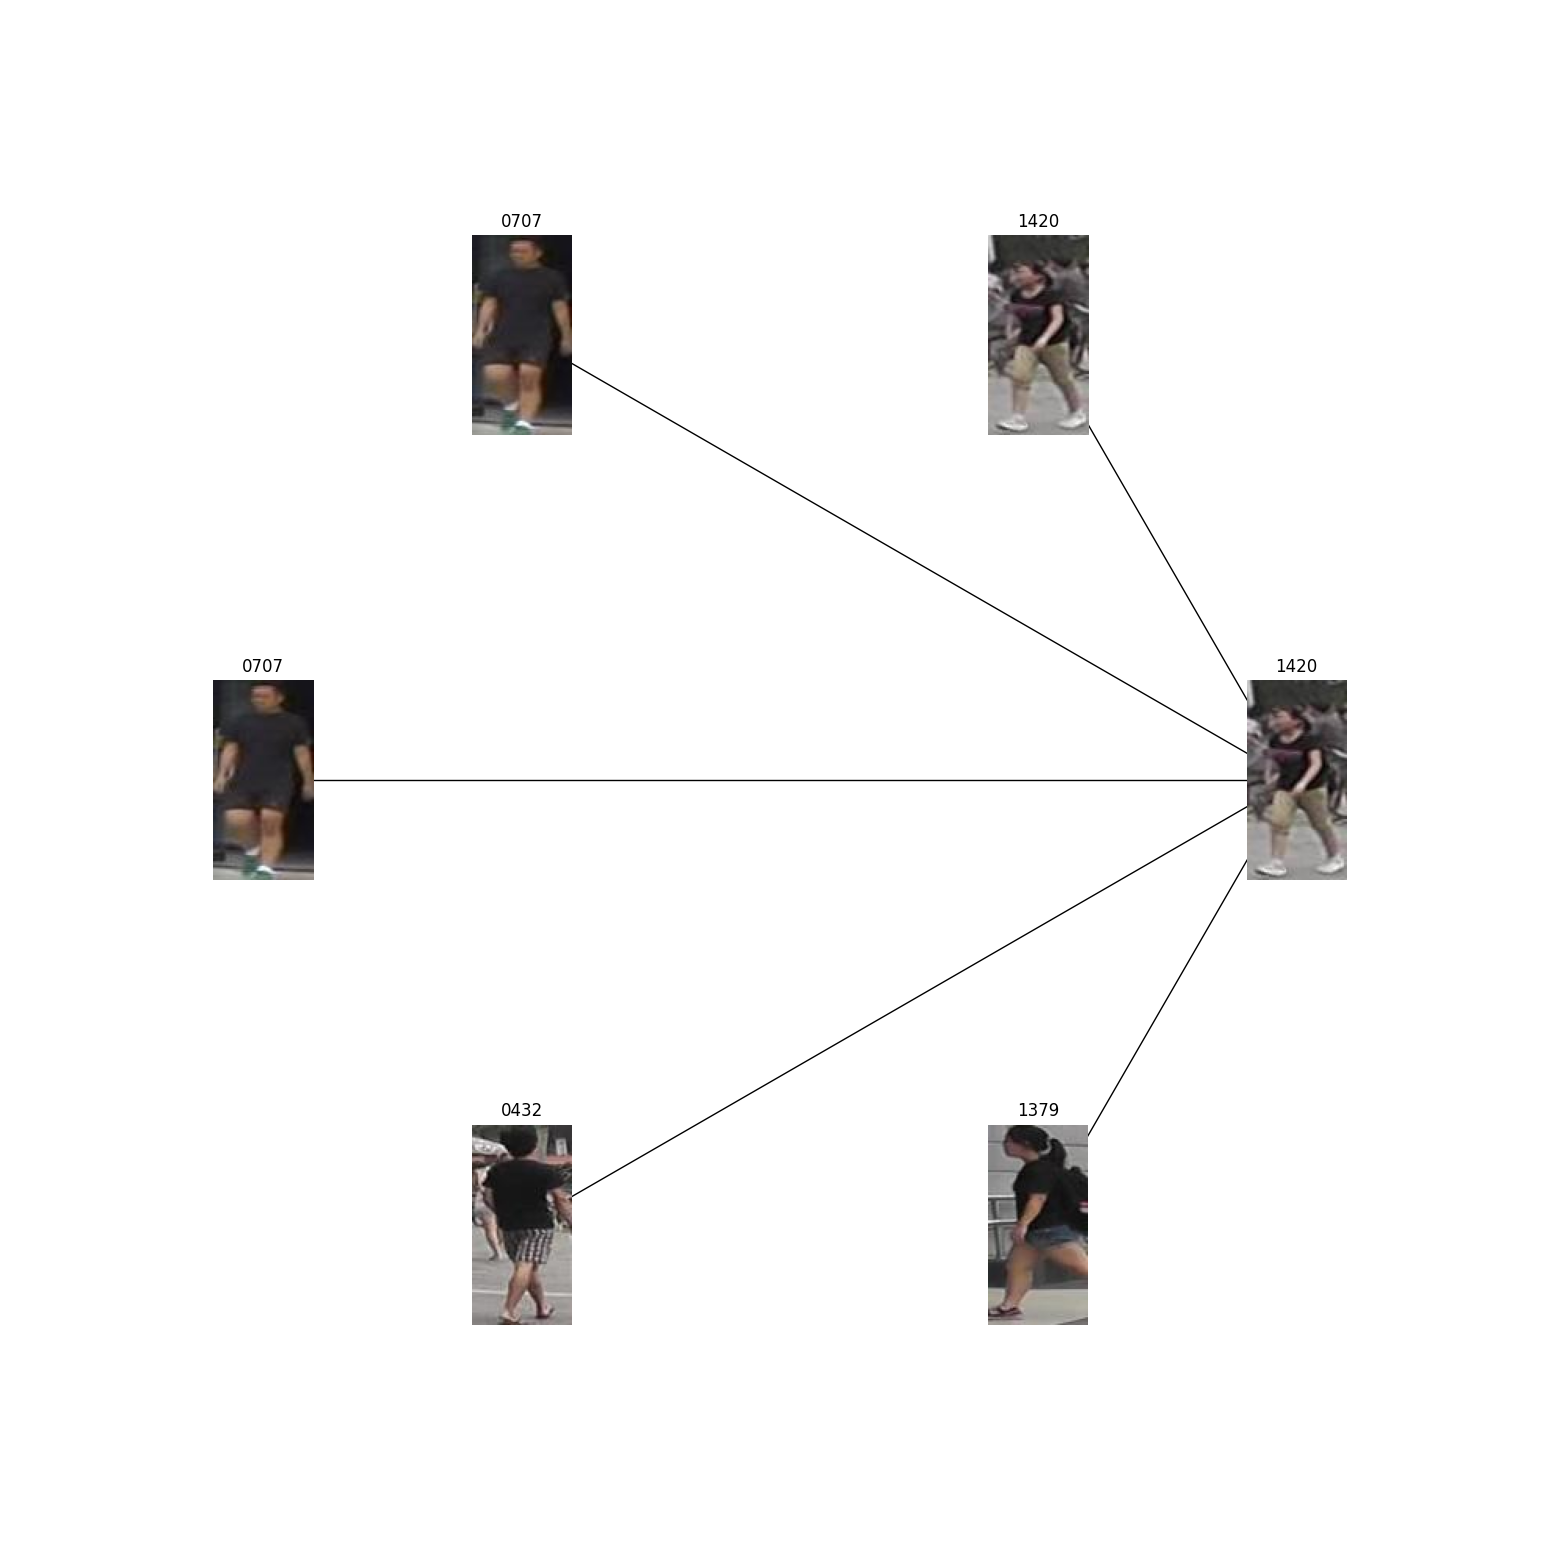

In [40]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);